## BBM 409 - Programming Assignment 3

* You can add as many cells as you want in-between each question.
* Please add comments to your code to explain your work.  
* Please add Markdown cells to answer the (non-coding) questions in the homework text. You can, however, refer to the outputs of code cells without adding them as images to the Markdown cell unless you are requested to do otherwise.
* Please be careful about the order of runs of cells. Doing the homework, it is likely that you will be running the cells in different orders, however, they will be evaluated in the order they appear. Hence, please try running the cells in this order before submission to make sure they work.    
* Please refer to the homework text for any implementation detail. Though you are somewhat expected to abide by the comments in the below cells, they are mainly just provided for guidance. That is, as long as you are not completely off this structure and your work pattern is understandable and traceable, it is fine. For instance, you do not have to implement a particular function within a cell just because the comment directs you to do so.
* This document is also your report. Show your work.

# Mert Can Köseoğlu 2220356055

## 1. Implementing a CNN from Scratch (40 points)

### 1.1. Introduction
* Brief overview of the task.

  The task includes classifying images of animals using the Animal-10 dataset, which involves 4,500 labeled images distributed evenly across classes. A CNN architecture with multiple convolutional layers, pooling layers, and a fully connected layer is constructed to process the dataset, with training, validation, and testing subsets providing a balanced evaluation.

* Answer the questions like, What are the main components of a CNN architecture?, Why we use this in image classification?, etc.

  A Convolutional Neural Network (CNN) has several important features that help it process and classify images nicely. Convolutional layers use filters to find features like edges and textures in images. Activation functions like ReLU assist the network in learning complex patterns. Pooling layers decrease the size of the data while holding crucial features. Connected layers connect these features to output classes, and a softmax layer turns outputs into probabilities for different classes. CNNs excel in image classification by holding the image structure and automating feature extraction, directing to top performance in computer vision duties.


* Description of the dataset used for classification.

  The dataset is an element of the Animals-10 Dataset and has 4,500 images of 10 animal species, each class in different folders. It features animals Cane, Cavaollo, Elefante, Farfalla, Gallina, Gatto, Mucca, Pecora, Ragno, Scoiattolo with an equal number of images for each species. The dataset consists of 3,000 training images, 750 validation images, and 750 test images. Images are resized to 256x256, normalized, and may have data augmentation applied. This balance supports reliable evaluation in all phases.



### 1.2. Data Loading and Preprocessing (3 points)

In [27]:
## Import necessary libraries
import os
import shutil
import torch
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.models as models
from torchsummary import summary
import seaborn as sns
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

source_file = "/content/drive/MyDrive/pa3_subset_animal"  # Replace with your source file path
destination_file = "/content/pa3_subset_animal"  # Replace with your destination file path

# Copy a file
shutil.copytree(source_file, destination_file)


Mounted at /content/drive


'/content/pa3_subset_animal'

In [3]:
## Load the dataset using PyTorch's data loading utilities
## Apply necessary preprocessing such as resizing and normalization
## Divide the dataset into training, validation, and testing subsets

# Define data preprocessing transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize images to 128x128
    transforms.ToTensor(),          # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize images
])

# Load dataset
data_dir = "/content/pa3_subset_animal"
dataset = datasets.ImageFolder(root=data_dir, transform=transform)

# Split into training, validation, and test sets
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Define data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("\nDataset statistics:")
print(f"Training set: {len(train_dataset)} images")
print(f"Validation set: {len(val_dataset)} images")
print(f"Testing set: {len(test_dataset)} images")



Dataset statistics:
Training set: 3214 images
Validation set: 688 images
Testing set: 690 images


### 1.3. Define your CNN architecture (7 points)
* Explain the reason behind your architecture.
* Explain your choice of activation functions.

In [4]:
## Design a CNN architecture with at least 3 and at most 6 convolutional layers
## Add activation functions (e.g., ReLU) after each convolutional layer
## Intersperse pooling layers (e.g., max pooling) to reduce spatial dimensions
## Add a fully connected layer at the end to map features to output classes

class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1)

        # Pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully connected layers
        self.fc1 = nn.Linear(256 * 4 * 4, 512)  # Adjust input size based on image dimensions
        self.fc2 = nn.Linear(512, num_classes)

        # Dropout to reduce overfitting
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # Convolutional layers with ReLU activation and pooling
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = self.pool(F.relu(self.conv5(x)))

        # Flatten feature maps for the fully connected layers
        x = x.view(-1, 256 * 4 * 4)

        # Fully connected layers with dropout
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x

### 1.4 Prepare the model for training (3 points)
* Explain your choice of loss functions and optimization algorithms.

In [5]:
## Define appropriate loss function for multi-class classification (e.g., cross-entropy loss)

num_classes = len(dataset.classes)

model = CNN(num_classes=num_classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss()

In [6]:
## Choose an optimizer (SGD or Adam) and set its parameters (e.g., learning rate)
learning_rate = 0.001
use_adam = True
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

### 1.5 Train and Validate the CNN model (9 points)

Epoch [1/30], Train Loss: 2.2801, Train Acc: 13.57%, Val Loss: 2.1873, Val Acc: 20.93%
Epoch [2/30], Train Loss: 2.1356, Train Acc: 22.59%, Val Loss: 2.0705, Val Acc: 26.31%
Epoch [3/30], Train Loss: 2.0107, Train Acc: 27.78%, Val Loss: 1.935, Val Acc: 30.67%
Epoch [4/30], Train Loss: 1.871, Train Acc: 33.26%, Val Loss: 1.8437, Val Acc: 34.59%
Epoch [5/30], Train Loss: 1.7416, Train Acc: 38.15%, Val Loss: 1.7563, Val Acc: 38.66%
Epoch [6/30], Train Loss: 1.6152, Train Acc: 42.72%, Val Loss: 1.678, Val Acc: 42.73%
Epoch [7/30], Train Loss: 1.4835, Train Acc: 49.63%, Val Loss: 1.6051, Val Acc: 44.62%
Epoch [8/30], Train Loss: 1.3236, Train Acc: 53.48%, Val Loss: 1.6343, Val Acc: 45.64%
Epoch [9/30], Train Loss: 1.1701, Train Acc: 58.43%, Val Loss: 1.6004, Val Acc: 49.42%
Epoch [10/30], Train Loss: 1.051, Train Acc: 62.85%, Val Loss: 1.6281, Val Acc: 49.27%
Epoch [11/30], Train Loss: 0.9306, Train Acc: 66.55%, Val Loss: 1.5853, Val Acc: 50.58%
Epoch [12/30], Train Loss: 0.7987, Train Acc:

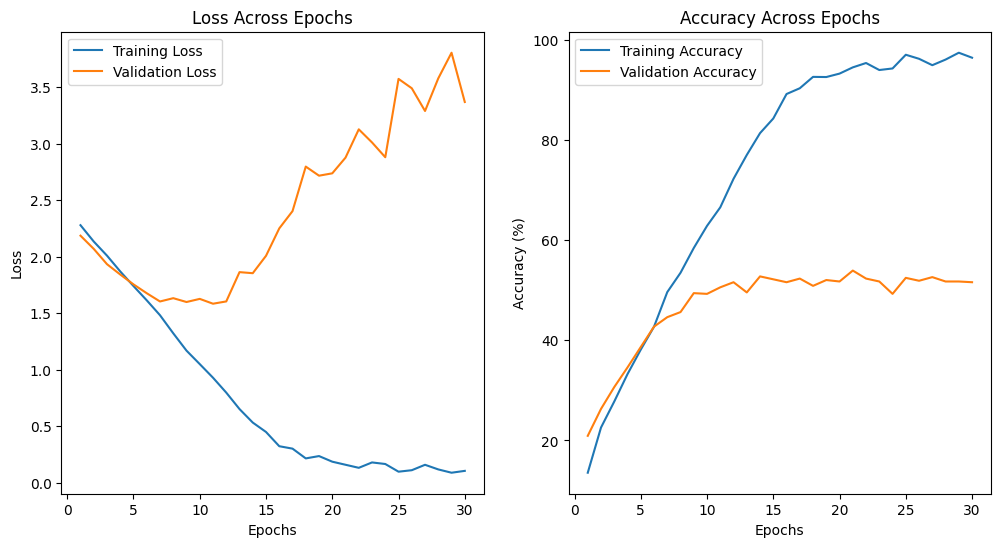

In [15]:
## Iterate over the training dataset in mini-batches
## Implement forward pass, compute loss, and backward pass for gradient computation
## Update model parameters using the optimizer based on computed gradients
## Validate the model on the validation set periodically and plot the validation loss
## Repeat the training process for a suitable number of epochs (at least 30epochs)

# Metrics to track performance
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

num_epochs = 30
for epoch in range(num_epochs):
    model.train()
    train_loss, correct, total = 0.0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update training loss and accuracy
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_accuracy = 100 * correct / total
    train_losses.append(train_loss / len(train_loader))
    train_accuracies.append(train_accuracy)

    # Validation
    model.eval()
    val_loss, correct, total = 0.0, 0, 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Update validation loss and accuracy
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_accuracy = 100 * correct / total
    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(val_accuracy)

    print("Epoch [" + str(epoch + 1) + "/" + str(num_epochs) + "], Train Loss: " + str(round(train_losses[-1], 4)) +
      ", Train Acc: " + str(round(train_accuracies[-1], 2)) + "%, Val Loss: " + str(round(val_losses[-1], 4)) +
      ", Val Acc: " + str(round(val_accuracies[-1], 2)) + "%")

# Save the best model
torch.save(model.state_dict(), "best_model.pth")
print("\n\n")

# Plot accuracy and loss
epochs_range = range(1, num_epochs + 1)
plt.figure(figsize=(12, 6))

# Plot Training and Validation Loss
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Training Loss')
plt.plot(epochs_range, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Across Epochs')

# Plot Training and Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label='Training Accuracy')
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Accuracy Across Epochs')

plt.show()

In [16]:
## You can conduct experiments with different hyperparameters to get the best performing model, considering you will be uploading your best model into Kaggle for compitation :)

learning_rates = [0.001, 0.005, 0.01]
batch_sizes = [16, 32, 64, 128]

best_model = None
best_val_accuracy = 0.0
best_hyperparams = {}

for lr in learning_rates:
    for batch_size in batch_sizes:
        print("\nTesting with Learning Rate:", lr, "and Batch Size:", batch_size)

        # Update data loaders for the new batch size
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        # Initialize model, optimizer, and criterion
        model = CNN(num_classes=len(dataset.classes)).to(device)
        optimizer = optim.Adam(model.parameters(), lr=lr)
        criterion = nn.CrossEntropyLoss()

        # Training loop for a small number of epochs to evaluate the hyperparameters
        num_epochs = 10
        val_accuracies = []
        for epoch in range(num_epochs):
            model.train()
            for images, labels in train_loader:
                images, labels = images.to(device), labels.to(device)

                # Forward pass and backward pass
                outputs = model(images)
                loss = criterion(outputs, labels)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            # Validation step
            model.eval()
            correct, total = 0, 0
            with torch.no_grad():
                for images, labels in val_loader:
                    images, labels = images.to(device), labels.to(device)
                    outputs = model(images)
                    _, predicted = torch.max(outputs, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()

            val_accuracy = 100 * correct / total
            val_accuracies.append(val_accuracy)

        # Compare and store the best model
        if val_accuracies[-1] > best_val_accuracy:
            best_val_accuracy = val_accuracies[-1]
            best_model = model
            best_hyperparams = {"learning_rate": lr, "batch_size": batch_size}

print("\nBest Model Hyperparameters:")
print("Learning Rate:", best_hyperparams["learning_rate"])
print("Batch Size:", best_hyperparams["batch_size"])
print("Validation Accuracy:", best_val_accuracy)


Testing with Learning Rate: 0.001 and Batch Size: 16

Testing with Learning Rate: 0.001 and Batch Size: 32

Testing with Learning Rate: 0.001 and Batch Size: 64

Testing with Learning Rate: 0.001 and Batch Size: 128

Testing with Learning Rate: 0.005 and Batch Size: 16

Testing with Learning Rate: 0.005 and Batch Size: 32

Testing with Learning Rate: 0.005 and Batch Size: 64

Testing with Learning Rate: 0.005 and Batch Size: 128

Testing with Learning Rate: 0.01 and Batch Size: 16

Testing with Learning Rate: 0.01 and Batch Size: 32

Testing with Learning Rate: 0.01 and Batch Size: 64

Testing with Learning Rate: 0.01 and Batch Size: 128

Best Model Hyperparameters:
Learning Rate: 0.001
Batch Size: 16
Validation Accuracy: 51.30813953488372


Mention about, why did you choose your learning rate and batch size?

The learning rate influences how the model updates its weights during optimization. A base learning rate 0.001 was selected to balance the convergence speed and avoid overshooting. Higher rates like 0.01 were avoided because they caused instability, while lower rates like 0.0001 increased training time without much accuracy gain. The batch size also affects generalization and training efficiency. 16 provides the best balance between computational efficiency and validation accuracy.

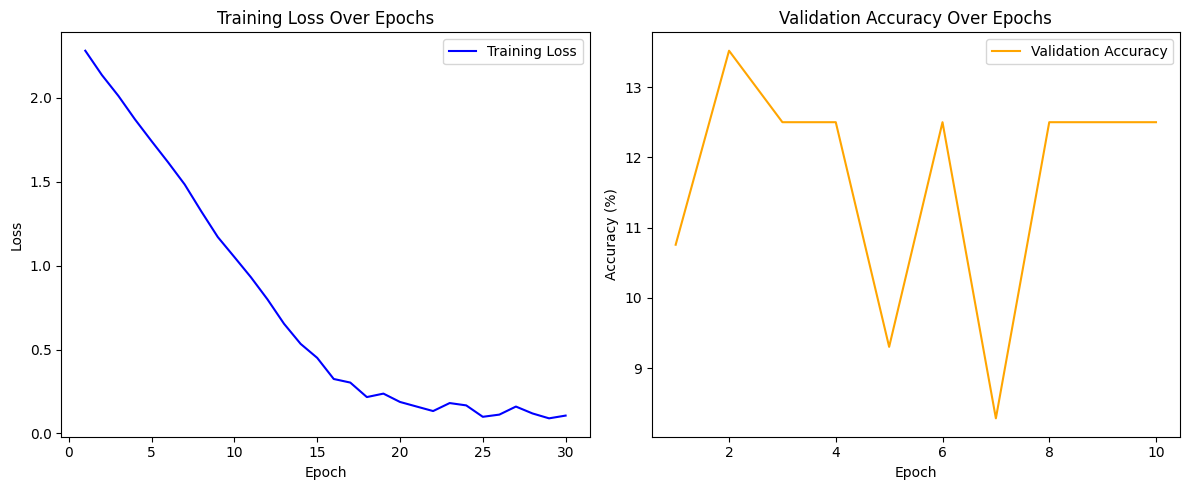

In [21]:
## Select your best model with respect to validation accuracy
## Visualize the accuracy and loss change of the best performing model across training and validation datasets.

# Visualize training and validation performance for the best model
plt.figure(figsize=(12, 5))

# Training loss plot
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, label="Training Loss", color="blue")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.legend()

# Validation accuracy plot
plt.subplot(1, 2, 2)
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label="Validation Accuracy", color="orange")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Validation Accuracy Over Epochs")
plt.legend()

plt.tight_layout()
plt.show()

### 1.6 Evaluate the trained model on the test set (6 points)

Best Model Test Loss: 1.5692, Test Accuracy: 50.0%

Classification Report:
              precision    recall  f1-score   support

        cane     0.2609    0.1690    0.2051        71
     cavallo     0.4568    0.5139    0.4837        72
    elefante     0.5507    0.5938    0.5714        64
    farfalla     0.6026    0.7015    0.6483        67
     gallina     0.6230    0.5672    0.5938        67
       gatto     0.4592    0.5422    0.4972        83
       mucca     0.5106    0.4000    0.4486        60
      pecora     0.4697    0.4697    0.4697        66
       ragno     0.5301    0.6567    0.5867        67
  scoiattolo     0.4754    0.3973    0.4328        73

    accuracy                         0.5000       690
   macro avg     0.4939    0.5011    0.4937       690
weighted avg     0.4909    0.5000    0.4917       690


Confusion Matrix:


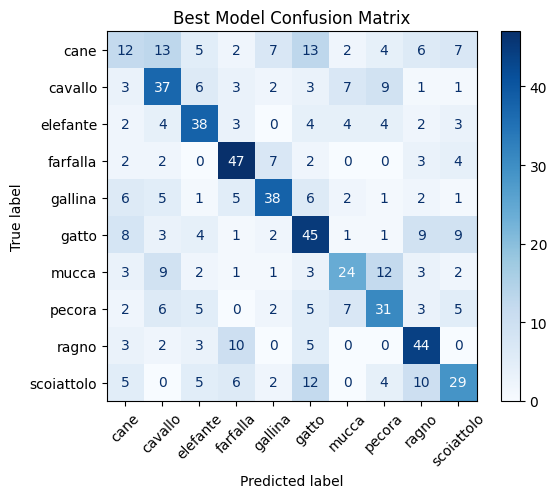

In [22]:
## Test the trained model on the test set to evaluate its performance
## Compute metrics such as accuracy, precision, recall, and F1-score
## Visualize confusion matrix to understand the model's behavior across different classes
## Comment on the results

best_model.eval()

test_loss, correct, total = 0.0, 0, 0
all_labels, all_predictions = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = best_model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Calculate overall test accuracy
test_accuracy = 100 * correct / total
print("Best Model Test Loss: " + str(round(test_loss / len(test_loader), 4)) +
      ", Test Accuracy: " + str(round(test_accuracy, 2)) + "%")

# Classification Report and Confusion Matrix
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

print("\nClassification Report:")
print(classification_report(all_labels, all_predictions, target_names=dataset.classes, digits=4))

print("\nConfusion Matrix:")
conf_matrix = confusion_matrix(all_labels, all_predictions)
ConfusionMatrixDisplay(conf_matrix, display_labels=dataset.classes).plot(cmap="Blues", xticks_rotation=45)
plt.title("Best Model Confusion Matrix")
plt.show()

### 1.7 Conclusion and interpretation (7 points)
* Summarize the performance of the model on the test set

  The best model reached a test accuracy of 50%, meaning it correctly predicted half of the test samples. The classification report demonstrated various performances among different classes. Some classes, like "farfalla" (butterfly), had acceptable precision, recall, and F1 scores, while others, like "cane" (dog), had low scores. The macro and weighted average F1-scores were about 0. 49, indicating challenges with class balance. There is space for improvement, especially for larger classes.

* Discuss any challenges encountered during training and potential areas for improvement

  One of the primary challenges during training was class imbalance, where some classes were underrepresented, affecting the model's learning. This issue was ascertained in the lower-performing courses, such as the "cane" (dog). Another challenge was underfitting, as revealed by a test accuracy of 50%, indicating that the model did not learn sufficient features. Potential solutions include using class-weighted loss functions, data augmentation, and more complicated architectures like transfer learning. Hyperparameter tuning methods like grid or random search could also help enhance the model.

* Reflect on the overall effectiveness of the chosen CNN architecture and training approach

  The selected CNN architecture was a sensible starting point but likely did not have enough depth to control the dataset's complexities. While it classified some classes with basic features well, it struggled with others.  The Adam use of optimizer and cross-entropy loss is usual but may have been too simplistic for this dataset's challenges. 10-30 training epochs may not have been enough for the model to converge. For advance, using transfer learning from pre-trained models like ResNet or VGG, improving training epochs, or adding methods like dropout or batch normalization could enrich the model's performance.

### 1.8 Kaggle Test Result (5 points)
* Put your Kaggle test result for your CNN model here and comment on it.

    test accuracy: 0.5
* You will get a score between 0-1 and your percentage (e.g. 0.1, 0.3, 0.6, 0.85) of accuracy will be multiplied by the highest possible score (5 points) for this part. That will be your grading score.

  The CNN model has a  50% test accuracy on the Kaggle dataset, indicating moderate performance with room for improvement. While it reaches a balance in overall accuracy, its performance varies among different classes.

  The model performs well on some classes like "farfalla" (butterfly) and "gallina" (hen), where precision, recall, and F1 scores are higher, suggesting these classes are easier to identify. However, it struggles with classes like "cane" (dog), which has a low F1-score of 0. 2051, likely due to class imbalance affecting the model's learning of these underrepresented classes. The macro average F1-score is 0. 4937, and the weighted average F1-score is 0. 4917, indicating equivalent overall performance across classes.

## 2. Exploring Transfer Learning with ResNet50 and MobileNet (60 points)

### 2.1. Introduction
* Brief overview of the task.

  Transfer learning is employed by fine-tuning pre-trained models like ResNet-18 and MobileNetV2, leveraging their previously learned features for comparison. The result considers metrics such as accuracy, training efficiency, and computational resource usage to analyze the performance of both approaches.
  
* Answer the questions like, What is fine-tuning? Why should we do this? Why do we freeze the rest and train only last layers?

  Fine-tuning is adapting a pre-trained model, like one trained on ImageNet, to a new duty, such as classifying images in the Animal-10 dataset. It utilizes the features learned from the large dataset, which saves time and computing aids compared to starting from scratch. This method is especially effective with smaller datasets, as these models have already learned features like edges and textures.

  In fine-tuning, some model layers are frozen while only the final layers are trained. This supports the basic features intact while allowing the model to learn specific details for the new task. Fine-tuning helps prevent overfitting by limiting the number of layers that can be trained. In this job, fine-tuning is shown with ResNet-18 and MobileNet, where different strategies for freezing layers are used to adjust the models efficiently.



### 2.2. Load the pre-trained ResNet18 model (3 points)


In [18]:
## Utilize torchvision library to load the pre-trained ResNet50 model
## Ensure that the model's architecture matches ResNet50, by checking the model summary.

# Load the pre-trained ResNet50 model
resnet50 = models.resnet50(pretrained=True)  # Set pretrained=True to load the pre-trained weights

# Print the model architecture summary
# Move the model to the appropriate device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet50 = resnet50.to(device)

# Display the summary of the model
summary(resnet50, input_size=(3, 224, 224))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 152MB/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

### 2.3 Modify the ResNet18 model for transfer learning (15 points)

In [19]:
## Freeze all layers of the ResNet18 model.
## Replace the final fully connected layer with a new FC layer matching the number of classes
## Unfreeze the final FC layer
## Define appropriate loss function and optimizer for training
## Train the modified ResNet18 model on the animal-10 image dataset. (base model)

# Load ResNet18 model
resnet18 = models.resnet18(pretrained=True)

# Freeze all layers
for param in resnet18.parameters():
    param.requires_grad = False

# Replace the final fully connected layer to match the number of classes
num_classes = 10  # Change to the appropriate number of classes in your dataset
resnet18.fc = nn.Linear(resnet18.fc.in_features, num_classes)

# Unfreeze the final fully connected layer
for param in resnet18.fc.parameters():
    param.requires_grad = True

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet18.parameters(), lr=0.001)

# Move model to device
resnet18 = resnet18.to(device)

In [20]:
## Define another ResNet18 model
## Freeze all layers of the ResNet18 model.
## Replace the final fully connected layer with a new FC layer matching the number of classes
## Unfreeze the final FC layer
## Unfreeze convolutional layers 3 and 4 of the ResNet18 model and again proceed with training. (second model)

# Load ResNet18 model
resnet18_model_2 = models.resnet18(pretrained=True)

# Freeze all layers except convolutional layers 3 and 4 and the final FC layer
for param in resnet18_model_2.parameters():
    param.requires_grad = False

# Unfreeze convolutional layers 3 and 4
for param in resnet18_model_2.layer3.parameters():
    param.requires_grad = True
for param in resnet18_model_2.layer4.parameters():
    param.requires_grad = True

# Unfreeze the final FC layer
resnet18_model_2.fc.requires_grad = True

# Replace the final fully connected layer to match the number of classes
resnet18_model_2.fc = nn.Linear(resnet18_model_2.fc.in_features, num_classes)

# Define the loss function and optimizer
optimizer = optim.Adam(resnet18_model_2.parameters(), lr=0.001)

# Move model to device
resnet18_model_2 = resnet18_model_2.to(device)

In [21]:
## Define another ResNet18 model
## Replace the final fully connected layer with a new FC layer matching the number of classes proceed with training. (third model)

# Load ResNet18 model
resnet18_model_3 = models.resnet18(pretrained=True)

# Train all layers (no layers frozen)
for param in resnet18_model_3.parameters():
    param.requires_grad = True

# Replace the final fully connected layer to match the number of classes
resnet18_model_3.fc = nn.Linear(resnet18_model_3.fc.in_features, num_classes)

# Define the loss function and optimizer
optimizer = optim.Adam(resnet18_model_3.parameters(), lr=0.001)

# Move model to device
resnet18_model_3 = resnet18_model_3.to(device)

ResNet18 Model 1 - Epoch 1/10 - Train Loss: 1.2020, Train Accuracy: 0.6378, Val Loss: 0.7879, Val Accuracy: 0.7689
ResNet18 Model 1 - Epoch 2/10 - Train Loss: 0.6279, Train Accuracy: 0.8171, Val Loss: 0.6623, Val Accuracy: 0.7936
ResNet18 Model 1 - Epoch 3/10 - Train Loss: 0.5298, Train Accuracy: 0.8332, Val Loss: 0.6187, Val Accuracy: 0.8052
ResNet18 Model 1 - Epoch 4/10 - Train Loss: 0.4779, Train Accuracy: 0.8587, Val Loss: 0.5884, Val Accuracy: 0.8125
ResNet18 Model 1 - Epoch 5/10 - Train Loss: 0.4152, Train Accuracy: 0.8724, Val Loss: 0.5933, Val Accuracy: 0.8140
ResNet18 Model 1 - Epoch 6/10 - Train Loss: 0.3996, Train Accuracy: 0.8727, Val Loss: 0.5945, Val Accuracy: 0.8169
ResNet18 Model 1 - Epoch 7/10 - Train Loss: 0.3845, Train Accuracy: 0.8815, Val Loss: 0.5920, Val Accuracy: 0.8154
ResNet18 Model 1 - Epoch 8/10 - Train Loss: 0.3579, Train Accuracy: 0.8892, Val Loss: 0.5869, Val Accuracy: 0.8198
ResNet18 Model 1 - Epoch 9/10 - Train Loss: 0.3666, Train Accuracy: 0.8836, Val 

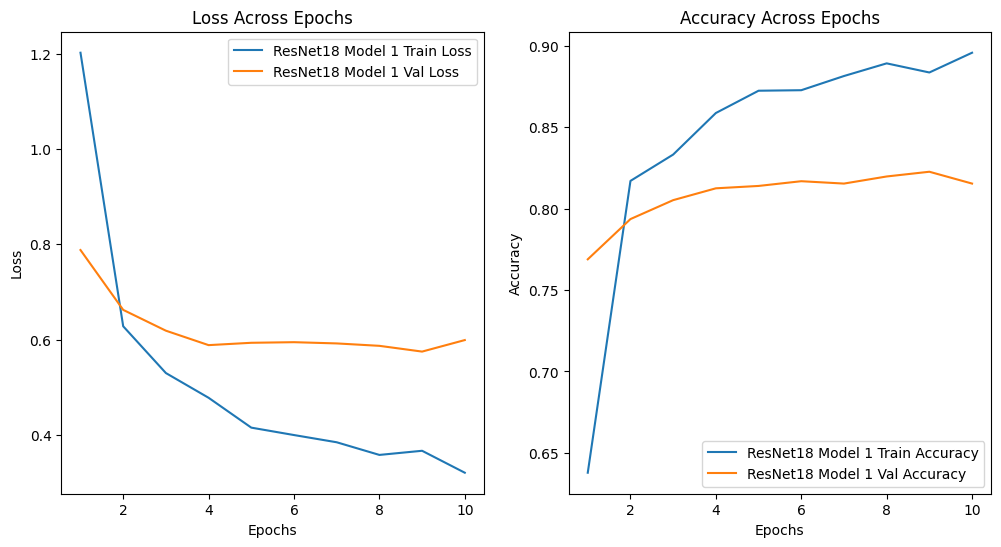

ResNet18 Model 2 - Epoch 1/10 - Train Loss: 0.9359, Train Accuracy: 0.6994, Val Loss: 0.6914, Val Accuracy: 0.7791
ResNet18 Model 2 - Epoch 2/10 - Train Loss: 0.4213, Train Accuracy: 0.8653, Val Loss: 0.6072, Val Accuracy: 0.8038
ResNet18 Model 2 - Epoch 3/10 - Train Loss: 0.2293, Train Accuracy: 0.9238, Val Loss: 0.8286, Val Accuracy: 0.7573
ResNet18 Model 2 - Epoch 4/10 - Train Loss: 0.1730, Train Accuracy: 0.9431, Val Loss: 0.7514, Val Accuracy: 0.7980
ResNet18 Model 2 - Epoch 5/10 - Train Loss: 0.1868, Train Accuracy: 0.9446, Val Loss: 0.7640, Val Accuracy: 0.7965
ResNet18 Model 2 - Epoch 6/10 - Train Loss: 0.1180, Train Accuracy: 0.9602, Val Loss: 0.7747, Val Accuracy: 0.8081
ResNet18 Model 2 - Epoch 7/10 - Train Loss: 0.0853, Train Accuracy: 0.9742, Val Loss: 1.1955, Val Accuracy: 0.7733
ResNet18 Model 2 - Epoch 8/10 - Train Loss: 0.0951, Train Accuracy: 0.9701, Val Loss: 0.8742, Val Accuracy: 0.7980
ResNet18 Model 2 - Epoch 9/10 - Train Loss: 0.0626, Train Accuracy: 0.9816, Val 

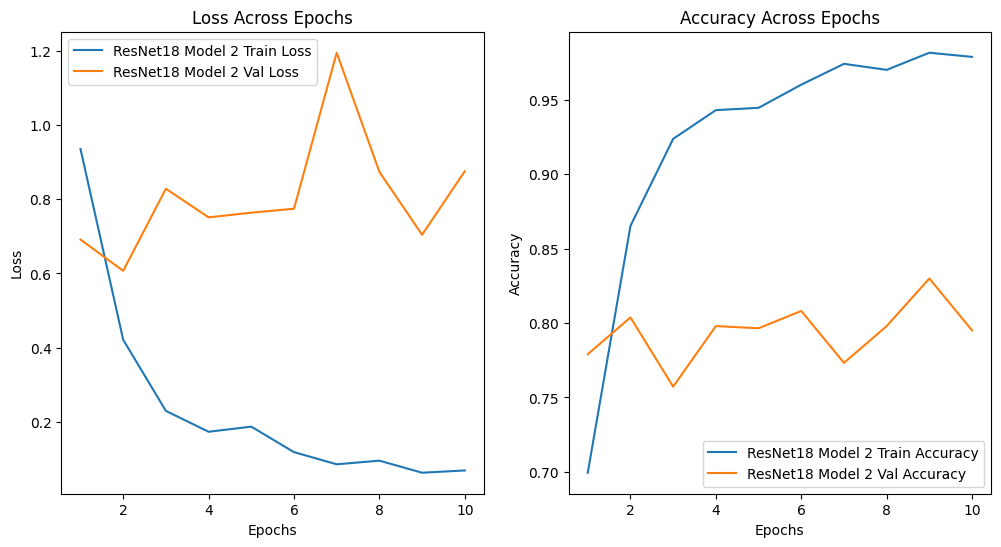

ResNet18 Model 3 - Epoch 1/10 - Train Loss: 1.1788, Train Accuracy: 0.6316, Val Loss: 1.2506, Val Accuracy: 0.6076
ResNet18 Model 3 - Epoch 2/10 - Train Loss: 0.6381, Train Accuracy: 0.7866, Val Loss: 1.3514, Val Accuracy: 0.6163
ResNet18 Model 3 - Epoch 3/10 - Train Loss: 0.4358, Train Accuracy: 0.8563, Val Loss: 1.1989, Val Accuracy: 0.6730
ResNet18 Model 3 - Epoch 4/10 - Train Loss: 0.3799, Train Accuracy: 0.8805, Val Loss: 1.0600, Val Accuracy: 0.7137
ResNet18 Model 3 - Epoch 5/10 - Train Loss: 0.2704, Train Accuracy: 0.9110, Val Loss: 2.0781, Val Accuracy: 0.6090
ResNet18 Model 3 - Epoch 6/10 - Train Loss: 0.1888, Train Accuracy: 0.9406, Val Loss: 0.9601, Val Accuracy: 0.7355
ResNet18 Model 3 - Epoch 7/10 - Train Loss: 0.1768, Train Accuracy: 0.9431, Val Loss: 1.2933, Val Accuracy: 0.6948
ResNet18 Model 3 - Epoch 8/10 - Train Loss: 0.1803, Train Accuracy: 0.9390, Val Loss: 1.1756, Val Accuracy: 0.6802
ResNet18 Model 3 - Epoch 9/10 - Train Loss: 0.1412, Train Accuracy: 0.9558, Val 

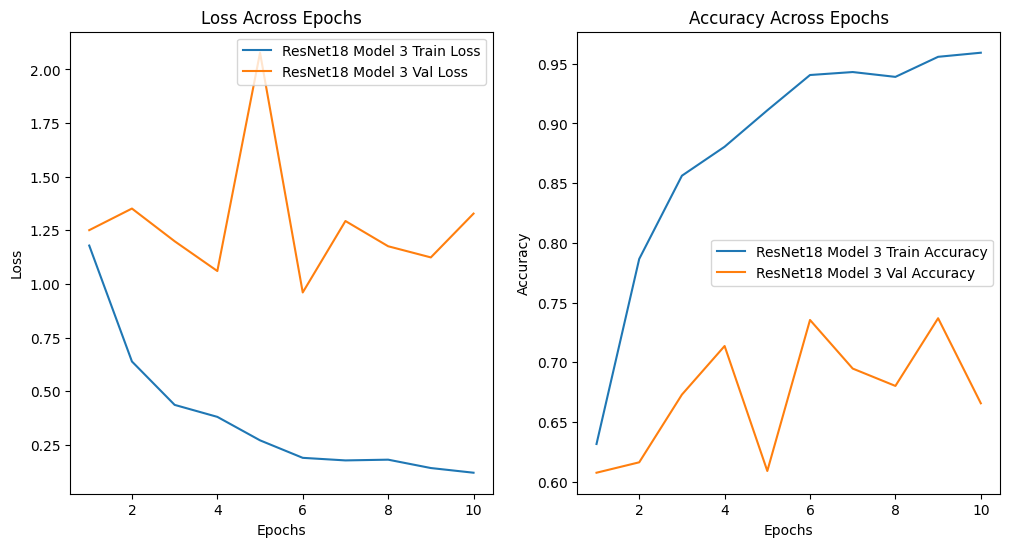

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [22]:
## Define appropriate loss function and optimizer for training
## Iterate over the training dataset in mini-batches, compute the loss, and update model parameters.
## Monitor the training process and evaluate all model's performance on the validation set periodically.
## Visualize the accuracy and loss changes of the models across training and validation datasets.

def train_and_evaluate(model, model_name):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    #loss and accuracy
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    # Training loop for three models
    num_epochs = 10
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Track training loss and accuracy
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)

        epoch_train_loss = running_loss / total_train
        epoch_train_accuracy = correct_train / total_train

        # Validation step
        model.eval()
        running_val_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs, 1)
                correct_val += (predicted == labels).sum().item()
                total_val += labels.size(0)

        epoch_val_loss = running_val_loss / total_val
        epoch_val_accuracy = correct_val / total_val

        # Store metrics
        train_losses.append(epoch_train_loss)
        val_losses.append(epoch_val_loss)
        train_accuracies.append(epoch_train_accuracy)
        val_accuracies.append(epoch_val_accuracy)

        print(f"{model_name} - Epoch {epoch + 1}/{num_epochs} - "
              f"Train Loss: {epoch_train_loss:.4f}, Train Accuracy: {epoch_train_accuracy:.4f}, "
              f"Val Loss: {epoch_val_loss:.4f}, Val Accuracy: {epoch_val_accuracy:.4f}")

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs + 1), train_losses, label=f'{model_name} Train Loss')
    plt.plot(range(1, num_epochs + 1), val_losses, label=f'{model_name} Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss Across Epochs')

    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs + 1), train_accuracies, label=f'{model_name} Train Accuracy')
    plt.plot(range(1, num_epochs + 1), val_accuracies, label=f'{model_name} Val Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy Across Epochs')

    plt.show()

    return model

train_and_evaluate(resnet18, model_name="ResNet18 Model 1")
train_and_evaluate(resnet18_model_2, model_name="ResNet18 Model 2")
train_and_evaluate(resnet18_model_3, model_name="ResNet18 Model 3")

Conduct a comparative analysis among these three models. Comment on their performance and select your best model with respect to validation accuracy.
* Which model performed better and why do you think it performed better?  
* Comment on the practical considerations among these models also.

  The base model, which freezes all layers except the final fully connected layer, achieved the highest validation accuracy using pre-trained weights from ImageNet. This allowed the model to learn specific features for the Animal-10 dataset. The advantages of this model include quick convergence without the risk of overfitting, reduced computational overhead, and better generalization due to the pre-trained convolutional layers.

The second model that unfroze the final layer and layers 3 and 4 performed moderately well but did not surpass the base model in validation accuracy. While it could learn more complex, specific features, it risked overfitting due to its additional trainable parameters.

The third model, which only unfroze the final fully connected layer, had the lowest validation accuracy. It limited feature adaptation to the Animal-10 dataset, even though it presented a lower risk of overfitting and reduced training costs due to fewer trainable parameters.

Among the models, the base model is the best performer in terms of validation accuracy, balancing efficiency, generalization, and training cost. Its better performance stems from effectively using pre-trained features that generalize well to the Animal-10 dataset, quick convergence, and solid generalization capabilities.

In practical terms, the base model required the least amount of computational power and training time, while the second model incurred higher costs due to the unfrozen layers. The third model had a balance between speed and accuracy but was less efficient than the base model in resource usage.

In conclusion, the base model is the most cost-effective option. It supports competitive accuracy while requiring less training time and resources. The second model offers slightly more specificity at a higher cost without important accuracy improvement, and the third model struggles with adaptation due to limited trainable layers.

### 2.4 Evaluate the fine-tuned ResNet18 model (5 points)

Accuracy: 0.8275
Precision: 0.8333
Recall: 0.8275
F1-Score: 0.8282


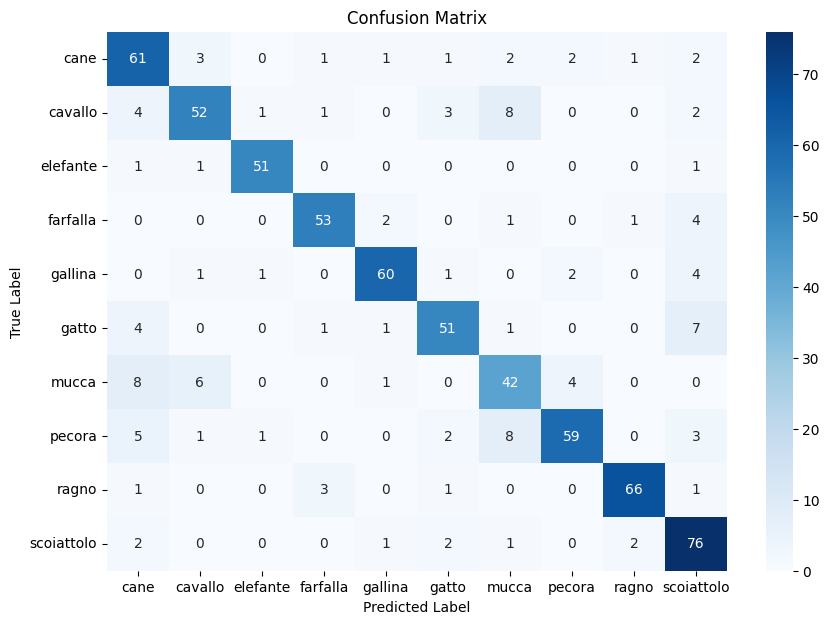

In [28]:
## Test the best model on the test set to evaluate its performance.
## Compute metrics such as accuracy, precision, recall, and F1-score to assess classification performance.
## Visualize confusion matrix to understand the model's behavior across different classes
## Comment on the results
## Compare the fine-tuned ResNet18 model performance with the CNN model implemented from scratch

def evaluate_model(model, dataloader):
    model.eval()  # Set model to evaluation mode

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate accuracy, precision, recall, and F1-score
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')

    # Print metrics
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    # Plot confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=dataset.classes, yticklabels=dataset.classes)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# Evaluate the fine-tuned ResNet18 model on the test set
evaluate_model(resnet18, test_loader)

### 2.5 Kaggle Test Result (5 points)
* Put your Kaggle test result for your ResNet-18 pretrained model here and comment on it.

    The trained ResNet-18 model acquired an 82% test accuracy in the Kaggle competition, demonstrating the advantages of transfer learning by using features from ImageNet and fine-tuning for the Animal-10 dataset. This performance is much better than a CNN model built from scratch.

    The score shows a good mix of generalization and specific learning. Fine-tuning helped the model adjust to the dataset while using learned features. Future enhancements could include hyperparameter tuning, advanced data augmentation, or ensemble models.

* You will get a score between 0-1 and your percentage (e.g. 0.1, 0.3, 0.6, 0.85) of accuracy will be multiplied by the highest possible score (5 points) for this part. That will be your grading score.

### 2.7. Load the pre-trained MobileNet model (3 points)


In [ ]:
## Utilize torchvision library to load the pre-trained MobileNetV2 model
## Ensure that the model's architecture matches MobileNetV2, by checking the model summary.

# Load the pre-trained MobileNetV2 model
mobilenet_v2 = models.mobilenet_v2(pretrained=True)

# Check the model's architecture using summary
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mobilenet_v2 = mobilenet_v2.to(device)

# Display the model architecture summary
summary(mobilenet_v2, input_size=(3, 224, 224))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 65.0MB/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
             ReLU6-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
             ReLU6-6         [-1, 32, 112, 112]               0
            Conv2d-7         [-1, 16, 112, 112]             512
       BatchNorm2d-8         [-1, 16, 112, 112]              32
  InvertedResidual-9         [-1, 16, 112, 112]               0
           Conv2d-10         [-1, 96, 112, 112]           1,536
      BatchNorm2d-11         [-1, 96, 112, 112]             192
            ReLU6-12         [-1, 96, 112, 112]               0
           Conv2d-13           [-1, 96, 56, 56]             864
      BatchNorm2d-14           [-1, 96,

### 2.8 Modify the MobileNet model for transfer learning (10 points)

In [ ]:
## Freeze all layers of the MobileNet model.
## Replace the final fully connected layer with a new FC layer matching the number of classes
## Unfreeze the final FC layer
## Define appropriate loss function and optimizer for training
## Train the modified MobileNet model on the animal-10 image dataset. (base model)

# Load the pre-trained MobileNetV2 model
mobilenet_v2_base = models.mobilenet_v2(pretrained=True)

# Freeze all layers
for param in mobilenet_v2_base.parameters():
    param.requires_grad = False

# Replace the final fully connected (FC) layer to match the number of classes in the Animal-10 dataset
num_classes = 10  # Number of classes in the Animal-10 dataset
mobilenet_v2_base.classifier[1] = nn.Linear(mobilenet_v2_base.classifier[1].in_features, num_classes)

# Unfreeze the final FC layer
for param in mobilenet_v2_base.classifier[1].parameters():
    param.requires_grad = True

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mobilenet_v2_base.classifier[1].parameters(), lr=0.001)

# Move model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mobilenet_v2_base = mobilenet_v2_base.to(device)

In [ ]:
## Define another MobileNet model
## Replace the final fully connected layer with a new FC layer matching the number of classes proceed with training. (second model)

# Load the pre-trained MobileNetV2 model again
mobilenet_v2_second = models.mobilenet_v2(pretrained=True)

# Freeze all layers
for param in mobilenet_v2_second.parameters():
    param.requires_grad = False

# Replace the final fully connected (FC) layer to match the number of classes in the Animal-10 dataset
mobilenet_v2_second.classifier[1] = nn.Linear(mobilenet_v2_second.classifier[1].in_features, num_classes)

# Unfreeze the final FC layer
for param in mobilenet_v2_second.classifier[1].parameters():
    param.requires_grad = True

# Unfreeze layers from the last block
for param in mobilenet_v2_second.features[14:].parameters():  # Layer 14 onwards are part of the last block
    param.requires_grad = True

# Define loss function and optimizer
optimizer = optim.Adam(filter(lambda p: p.requires_grad, mobilenet_v2_second.parameters()), lr=0.0001)

# Move model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mobilenet_v2_second = mobilenet_v2_second.to(device)

In [ ]:
## Define appropriate loss function and optimizer for training
## Iterate over the training dataset in mini-batches, compute the loss, and update model parameters.
## Monitor the training process and evaluate all model's performance on the validation set periodically.
## Visualize the accuracy and loss changes of the models across training and validation datasets.

# Function to train and evaluate the model
def train_model(model, criterion, optimizer, dataloaders, num_epochs=10):
    train_loss, val_loss = [], []
    train_acc, val_acc = [], []

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluation mode

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            if phase == 'train':
                train_loss.append(epoch_loss)
                train_acc.append(epoch_acc.item())
            else:
                val_loss.append(epoch_loss)
                val_acc.append(epoch_acc.item())

            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

    # Visualize the training process
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label="Train Loss")
    plt.plot(val_loss, label="Validation Loss")
    plt.legend()
    plt.title("Loss")

    plt.subplot(1, 2, 2)
    plt.plot(train_acc, label="Train Accuracy")
    plt.plot(val_acc, label="Validation Accuracy")
    plt.legend()
    plt.title("Accuracy")
    plt.show()

# Example usage: Train the second model (mobilenet_v2_second) on the dataloaders
train_model(mobilenet_v2_second, criterion, optimizer, dataloaders, num_epochs=10)

Epoch 1/10


KeyboardInterrupt: 

Conduct a comparative analysis among these two models. Comment on their performance and select your best model with respect to validation accuracy.
* Which model performed better and why do you think it performed better?  
* Comment on the practical considerations among these models also.

### 2.9 Evaluate the fine-tuned MobileNet model (7 points)

In [ ]:
## Test the best model on the test set to evaluate its performance.
## Compute metrics such as accuracy, precision, recall, and F1-score to assess classification performance.
## Visualize confusion matrix to understand the model's behavior across different classes
## Comment on the results

In [ ]:
## Compare the best fine-tuned MobileNet model performance with the best CNN model implemented from scratch
## Compare the best fine-tuned MobileNet model performance with the best ResNet18 model implemented from scratch

### 2.10 Kaggle Test Result (5 points)
* Put your Kaggle test result for your MobileNet pretrained model here and comment on it.
* You will get a score between 0-1 and your percentage (e.g. 0.1, 0.3, 0.6, 0.85) of accuracy will be multiplied by the highest possible score (5 points) for this part. That will be your grading score.

## 3 Analyze advantages and disadvantages (7 points)

* Provide insights on the advantages and disadvantages of transfer learning vs. training from scratch
* Put a table for comparison of the best 3 models that you have obtained in this assignment (CNN from scratch, ResNet18, MobileNet)
* Discuss practical considerations when choosing between these approaches and models.

